<a href="https://colab.research.google.com/github/EmilisEm/gmm/blob/master/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Author LSP: 2213748

#### Author: Emilis Kleinas

#### Variant: Classification model with `Printer`, `Cat` and `Tiger` classes

#### What does the program do

1. Downloads images for the specified classes from `OpenImages`.
2. Initiates a clasification model.
3. Trains the defined model.
4. Calculates confucion matrix, precision, accuracy, recall and F1 statistics for the downloaded images.


Needed imports

In [59]:
import torch
import os
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.io import read_image
from pathlib import Path
from tqdm import tqdm
import PIL.Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

## 1. Mount google drive to access and store images

In [60]:
!pip install openimages

In [69]:
from google.colab import drive
drive_base_uri = '/content/drive'
drive.mount(drive_base_uri)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
# The `data_dir` variable specifies the base directory to which the images will be saves.
# The images are stored as follows `{data_dir}/{class_name}/images/*.jpg`
# Where `class_name` is the name of the class being processed (e.g. "cow") in lowercase
data_dir = drive_base_uri + "/MyDrive/openimages"
number_of_images = 100
classes = ["Cat", "Tiger", "Printer"]

Download images for data classes (Optional if images already exist)

In [71]:
from openimages.download import download_dataset
download_dataset(data_dir, classes, limit=number_of_images)

100%|██████████| 94/94 [00:01<00:00, 47.66it/s]


{'cat': {'images_dir': '/content/drive/MyDrive/openimages/cat/images'},
 'tiger': {'images_dir': '/content/drive/MyDrive/openimages/tiger/images'},
 'printer': {'images_dir': '/content/drive/MyDrive/openimages/printer/images'}}

## 2. Initiate a classificaton model

### Define custom dataset

In [72]:
class CustomDataset(Dataset):
    def __init__(self, base_dir, transform):
        self.transform = transform
        self.samples = []

        for dataset_class in classes:
            class_path = Path(data_dir) / dataset_class.lower() / "images"
            if class_path.exists():
                self.samples.extend([(str(p), dataset_class) for p in class_path.glob('*.jpg')])

        print(f"Found {len(self.samples)} images")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, dataset_class = self.samples[idx]
        try:
            with PIL.Image.open(img_path) as img:
                img = img.convert('RGB')
                if self.transform:
                    img = self.transform(img)
                return img, 0, dataset_class
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            return torch.zeros((3, 224, 224)), 0, dataset_class

### Define transfroms

In [73]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Initiate datasets

In [74]:
dataset = CustomDataset(data_dir, transform=transform)
print(f"Dataset size: {len(dataset)} images")

train_size = int(0.8 * len(dataset))
validation_size = len(dataset) - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print(f"Training set size: {len(train_dataset)}")
print(f"Vaidation set size: {len(validation_dataset)}")


Found 300 images
Dataset size: 300 images
Training set size: 240
Vaidation set size: 60


### Initiate dataloaders

In [75]:
train_data_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1,
    prefetch_factor=2,
    persistent_workers=True,
    multiprocessing_context='fork'
)

validation_data_loader = DataLoader(
    validation_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=1,
    prefetch_factor=2,
    persistent_workers=True,
    multiprocessing_context='fork'
)

print(f"For trainging: {train_data_loader.num_workers} workers")
print(f"For validation: {validation_data_loader.num_workers} workers")


For trainging: 1 workers
For validation: 1 workers


### Create a simple convolutional neural network

In [76]:
import torch.nn as nn

class SimpleConvNet(torch.nn.Module):
    def __init__(self, in_shape, num_classes):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_shape[0], 16, 3, padding='same')
        self.pool1 = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(16, 32, 3, padding='same')
        self.pool2 = torch.nn.MaxPool2d(2, 2)
        self.conv3 = torch.nn.Conv2d(32, 64, 3, padding='same')
        self.pool3 = torch.nn.MaxPool2d(2, 2)

        feature_size = in_shape[1] // 8 * in_shape[2] // 8 * 64

        self.fc1 = torch.nn.Linear(feature_size, 128)
        self.fc2 = torch.nn.Linear(128, num_classes)

        self.flatten = torch.nn.Flatten()
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool3(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)

        return x

sample_inputs, _, _ = next(iter(train_data_loader))
in_shape = sample_inputs[0].shape
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = SimpleConvNet(in_shape, len(classes)).to(device)

print(f"Model: {model.__class__.__name__}")
print(f'Total parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}')

Model: SimpleConvNet
Total parameters: 2,121,251
Trainable parameters: 2,121,251


## 3. Training of the model

### Training function

In [78]:

def train_model(model, train_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    history = {
        'train_loss': [],
        'train_acc': []
    }

    model.train()

    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in train_loader:
            inputs, labels_unused, class_names = batch

            class_map = {'Printer': 0, 'Cat': 1, 'Tiger': 2}
            labels = torch.tensor([class_map[cls] for cls in class_names]).to(device)

            inputs = inputs.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct / total

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

    return model, history


### Training the model

In [79]:
print("Training new model...")
model, history = train_model(model, train_data_loader, num_epochs=10)
print("Model trained")

Training new model...
Epoch 1/10, Loss: 1.1058, Accuracy: 44.17%
Epoch 2/10, Loss: 1.0743, Accuracy: 49.58%
Epoch 3/10, Loss: 0.9821, Accuracy: 50.83%
Epoch 4/10, Loss: 0.9300, Accuracy: 55.00%
Epoch 5/10, Loss: 0.9075, Accuracy: 58.75%
Epoch 6/10, Loss: 0.7134, Accuracy: 70.83%
Epoch 7/10, Loss: 0.5997, Accuracy: 74.17%
Epoch 8/10, Loss: 0.4637, Accuracy: 83.75%
Epoch 9/10, Loss: 0.4736, Accuracy: 81.67%
Epoch 10/10, Loss: 0.3712, Accuracy: 83.33%
Model trained


## 4. Calculate statistics for model

Overall Metrics:
Accuracy: 0.6500
Precision (weighted): 0.6754
Recall (weighted): 0.6500
F1 Score (weighted): 0.6491

--------------------------------------------------

Per-Class Metrics:

Class: Cat
Precision: 0.6471
Recall: 0.5789
F1 Score: 0.6111
Accuracy: 0.5789 (11/19)

Class: Tiger
Precision: 0.5714
Recall: 0.8000
F1 Score: 0.6667
Accuracy: 0.8000 (16/20)

Class: Printer
Precision: 0.8000
Recall: 0.5714
F1 Score: 0.6667
Accuracy: 0.5714 (12/21)


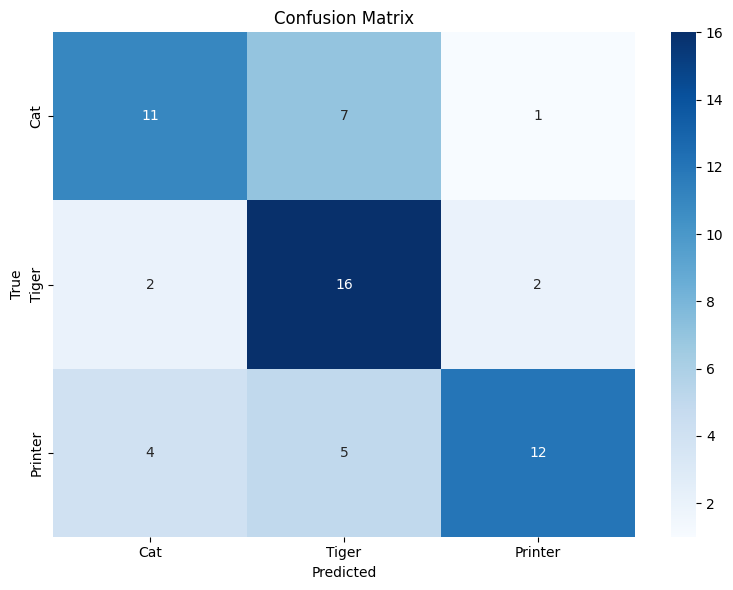

In [80]:

def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            inputs, _, class_names = batch

            class_map = {'Printer': 0, 'Cat': 1, 'Tiger': 2}
            labels = torch.tensor([class_map[cls] for cls in class_names]).to(device)

            inputs = inputs.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision_weighted = precision_score(all_labels, all_preds, average='weighted')
    recall_weighted = recall_score(all_labels, all_preds, average='weighted')
    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    precision_per_class = precision_score(all_labels, all_preds, average=None)
    recall_per_class = recall_score(all_labels, all_preds, average=None)
    f1_per_class = f1_score(all_labels, all_preds, average=None)

    conf_matrix = confusion_matrix(all_labels, all_preds)

    print("Overall Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (weighted): {precision_weighted:.4f}")
    print(f"Recall (weighted): {recall_weighted:.4f}")
    print(f"F1 Score (weighted): {f1_weighted:.4f}")
    print("\n" + "-"*50 + "\n")

    print("Per-Class Metrics:")
    for i, class_name in enumerate(classes):
        print(f"\nClass: {class_name}")
        print(f"Precision: {precision_per_class[i]:.4f}")
        print(f"Recall: {recall_per_class[i]:.4f}")
        print(f"F1 Score: {f1_per_class[i]:.4f}")

        class_samples = sum(1 for label in all_labels if label == i)
        class_correct = sum(1 for pred, label in zip(all_preds, all_labels)
                            if pred == label and label == i)
        class_accuracy = class_correct / class_samples if class_samples > 0 else 0
        print(f"Accuracy: {class_accuracy:.4f} ({class_correct}/{class_samples})")

    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return {
        'accuracy': accuracy,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'confusion_matrix': conf_matrix
    }

metrics = evaluate_model(model, validation_data_loader)
